# Chapter 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import talib
import seaborn as sns

In [19]:
lng_df = pd.read_hdf('lng_df.h5', key='lng_df')
lng_df.info()

feature_names = ['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30',
                 'ma50', 'rsi50', 'ma200', 'rsi200']

# Create features and targets
# use feature_names for features; 5d_close_future_pct for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295 entries, 2017-01-31 to 2018-04-03
Data columns (total 13 columns):
Adj_Close              295 non-null float64
Adj_Volume             295 non-null float64
5d_future_close        295 non-null float64
5d_close_future_pct    295 non-null float64
5d_close_pct           295 non-null float64
ma14                   295 non-null float64
rsi14                  295 non-null float64
ma30                   295 non-null float64
rsi30                  295 non-null float64
ma50                   295 non-null float64
rsi50                  295 non-null float64
ma200                  295 non-null float64
rsi200                 295 non-null float64
dtypes: float64(13)
memory usage: 32.3 KB


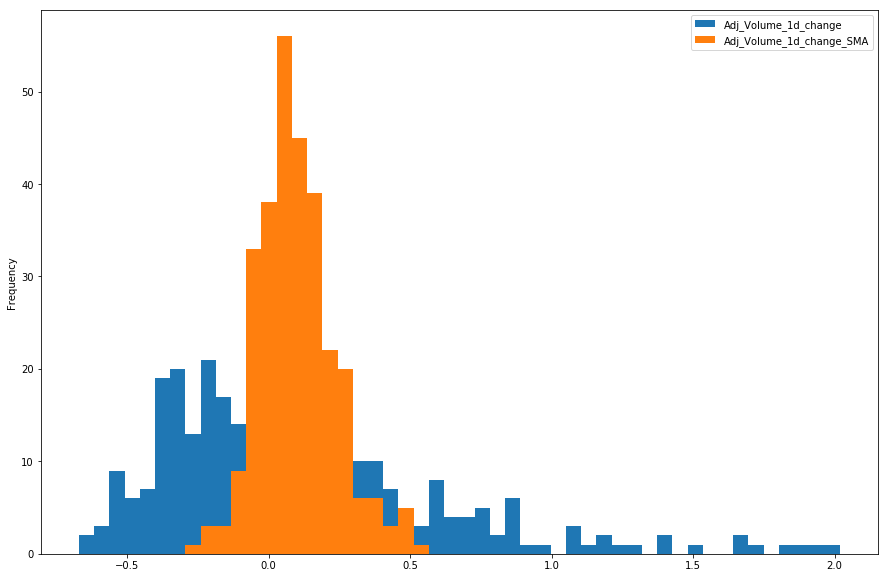

In [20]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values,
                        timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

In [21]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
print(lng_df.head())

            Adj_Close  Adj_Volume  5d_future_close  5d_close_future_pct  \
Date                                                                      
2017-02-07      47.81   2522644.0            47.88             0.001464   
2017-02-08      48.01   1521339.0            47.69            -0.006665   
2017-02-09      49.19   1717838.0            46.84            -0.047774   
2017-02-10      48.93   1747989.0            46.71            -0.045371   
2017-02-13      48.14   2321977.0            47.36            -0.016203   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
2017-02-07      0.003358  0.985448  58.654992  0.939476  58.817869  0.911801   
2017-02-08      0.019321  0.989333  59.351015  0.940047  59.182360  0.911289   
2017-02-09     -0.002838  0.974211  63.278848  0.922383  61.274321  0.893214   
2017-02-10     -0.010115  0.987957  61.860468  0.931821  60.566775  0.9020

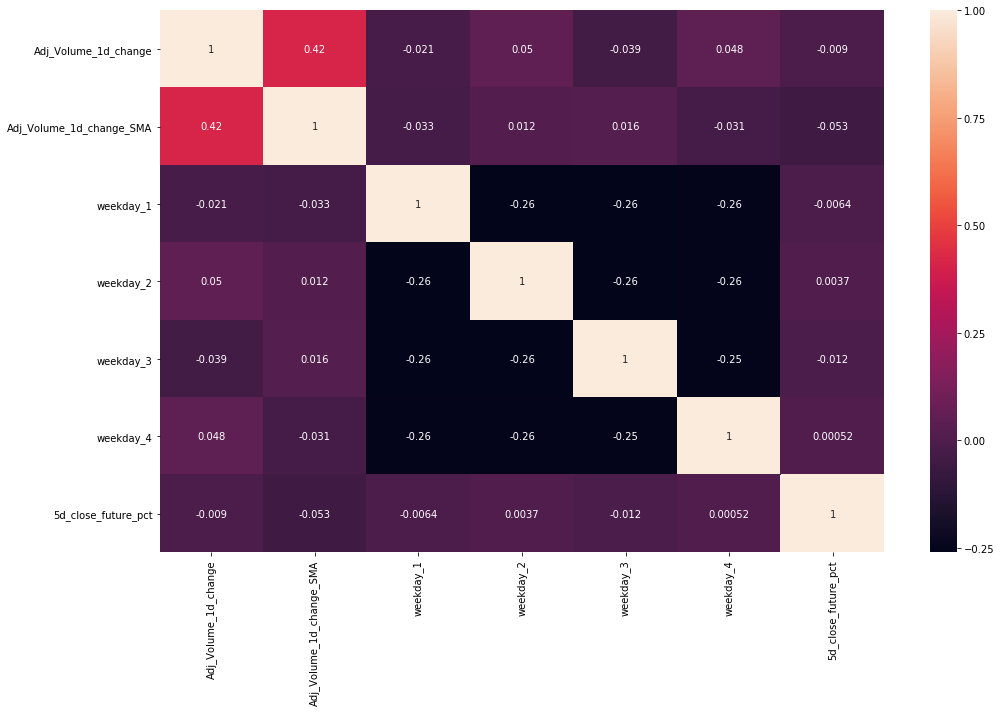

In [22]:
plt.rcParams['figure.figsize'] = (15,10)

# Add the weekday labels to the new_features list
new_features.extend(['weekday_'+str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

In [24]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9999950331816782
-1.3016054070355971


In [25]:
# Loop through a few different max depths and check the performance
for d in [3,5,10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.31221074754988065
-0.34425820543875796 

max_depth= 5
0.5300236519892909
-1.4252156719841511 

max_depth= 10
0.896998296863188
-0.30255389496624385 



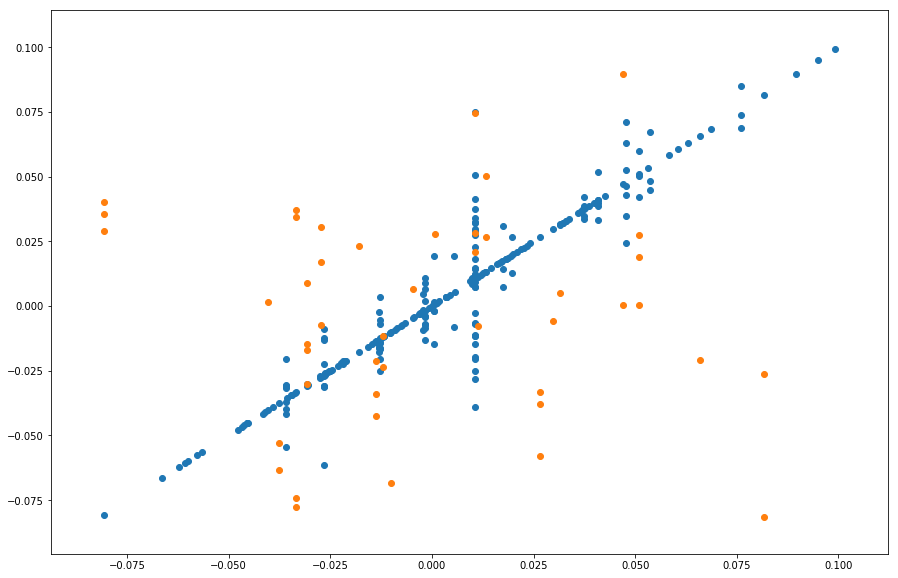

In [26]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.9189542505916549
-0.06799221274255962


In [29]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.026882387998738433 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


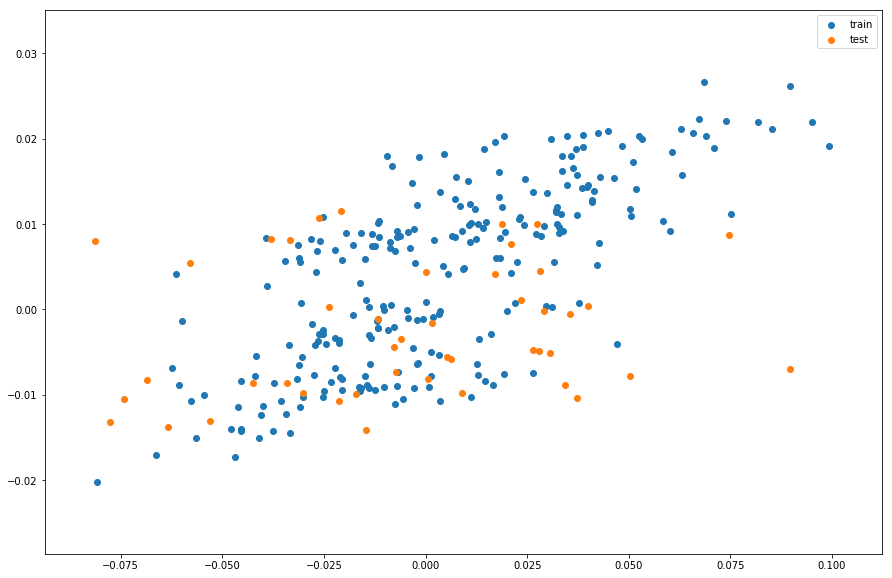

In [31]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=8, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

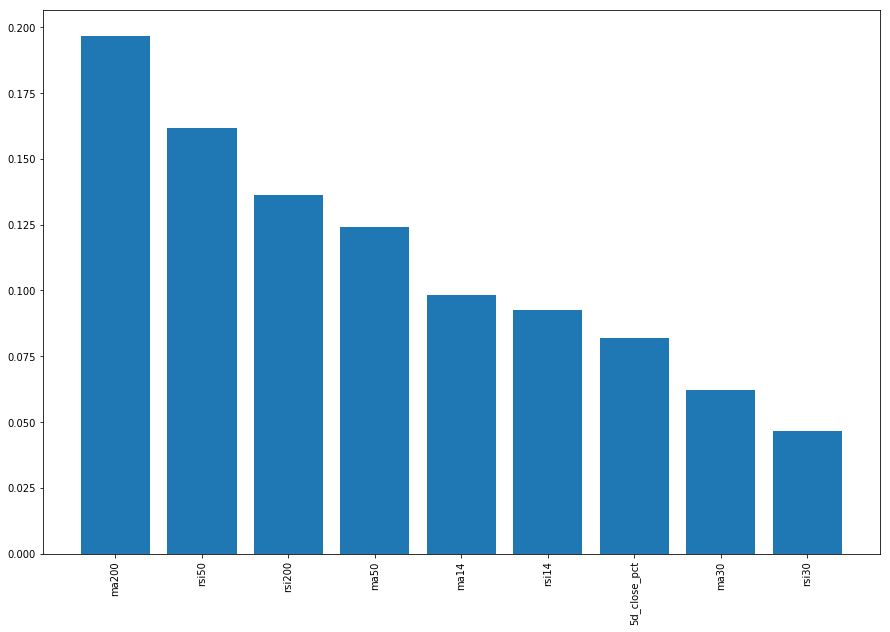

In [32]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.4440177798218924
0.03822632520187508


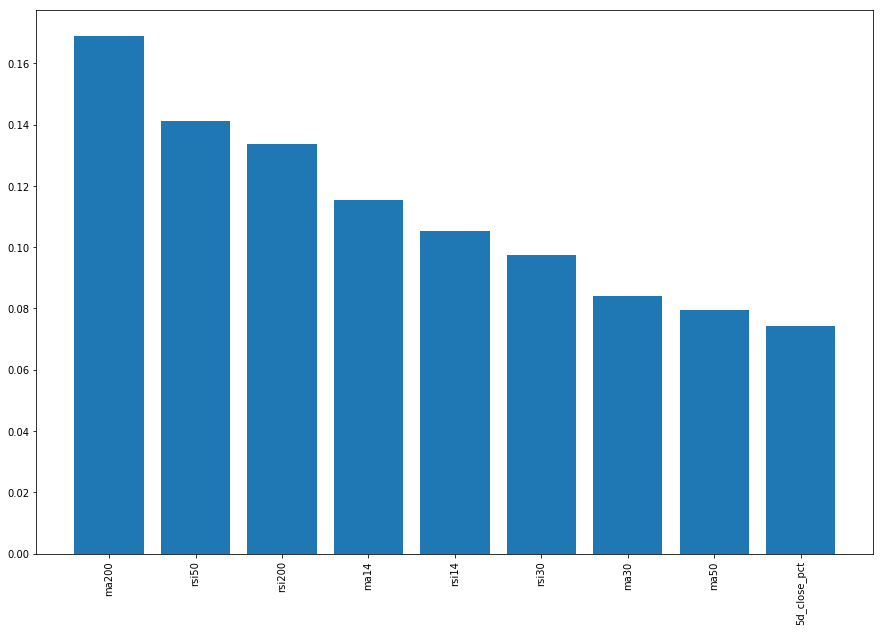

In [35]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()